In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

# final_project_path = '/Users/johansweldens/Documents/EECS6691.ADL/final_project' #local
final_project_path = '/home/jws2215' #local
data_folder_path = os.path.join(final_project_path, 'segment_data')
train_folder_path = os.path.join(data_folder_path, 'train')
valid_folder_path = os.path.join(data_folder_path, 'valid')


annotations_name = '_annotations.coco.json'
train_annotations_path = os.path.join(train_folder_path, annotations_name)
valid_annotations_path = os.path.join(valid_folder_path, annotations_name)

# Load annotations from JSON file
with open(train_annotations_path, 'r') as f:
    train_annotations_data = json.load(f)
with open(valid_annotations_path, 'r') as f:
    valid_annotations_data = json.load(f)

# Create a dictionary to map category IDs to category names
category_id_to_name = {category['id']: category['name'] for category in train_annotations_data['categories']}
print(train_annotations_data['info'])
# print(train_annotations_data['annotations'])
print(train_annotations_data['categories'])
print(train_annotations_data.keys())




# Extract categories from the annotations
categories = train_annotations_data['categories']

# Count the number of unique category IDs
num_classes = len(set([category['id'] for category in categories]))

print("Number of classes:", num_classes)



if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name: ", torch.cuda.get_device_name(0))
    allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert bytes to gigabytes
    cached_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Allocated Memory: {allocated_memory:.2f} GB")
    print(f"Cached Memory: {cached_memory:.2f} GB")
    total_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"Total GPU Memory: {total_memory:.2f} GB")
else:
    print("CUDA is not available. Cannot print memory usage.")
    device = torch.device('cpu')



{'year': '2023', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2023-08-19T04:37:54+00:00'}
[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'}, {'id': 1, 'name': '0', 'supercategory': 'Tumor'}, {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]
dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Number of classes: 3
GPU name:  Tesla T4
Allocated Memory: 0.00 GB
Cached Memory: 0.00 GB
Total GPU Memory: 14.58 GB


## Display the Images

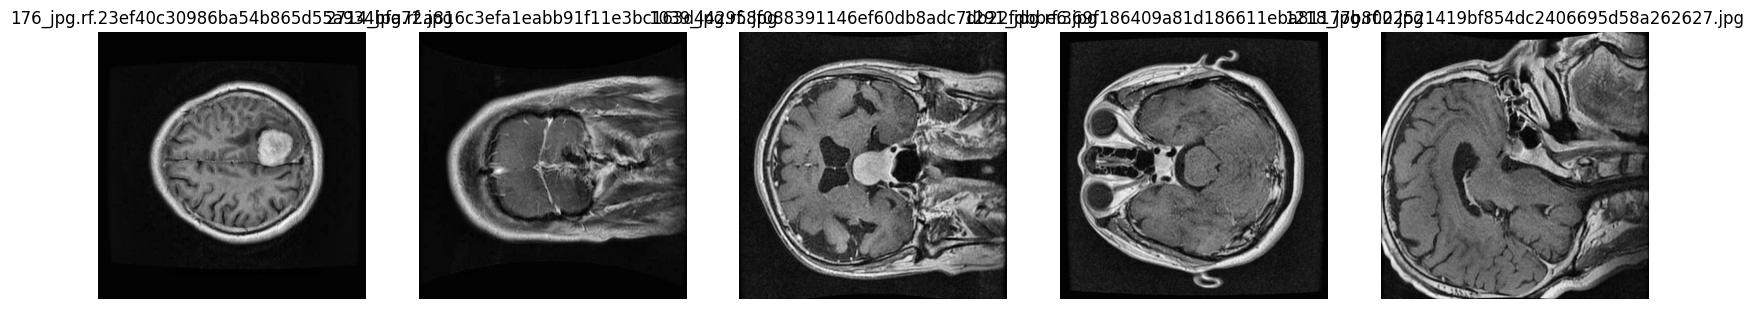

Number of Training Images: 1502


In [2]:
image_files = [f for f in os.listdir(train_folder_path) if f.endswith('.jpg')]

# Display 5 random images
num_images_to_display = 5
selected_images = np.random.choice(image_files, num_images_to_display, replace=False)

# Set up matplotlib figure
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))


# Loop through selected images and display them
for i, image_file in enumerate(selected_images):
    image_path = os.path.join(train_folder_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(image_file)

plt.show()
print("Number of Training Images:", len(image_files))

[84, 239, 103.75, 107.5]
[368, 218, 87.5, 88.75]
[300, 183, 95, 97.5]
[248, 225, 100, 100]
[159, 221, 95, 110]


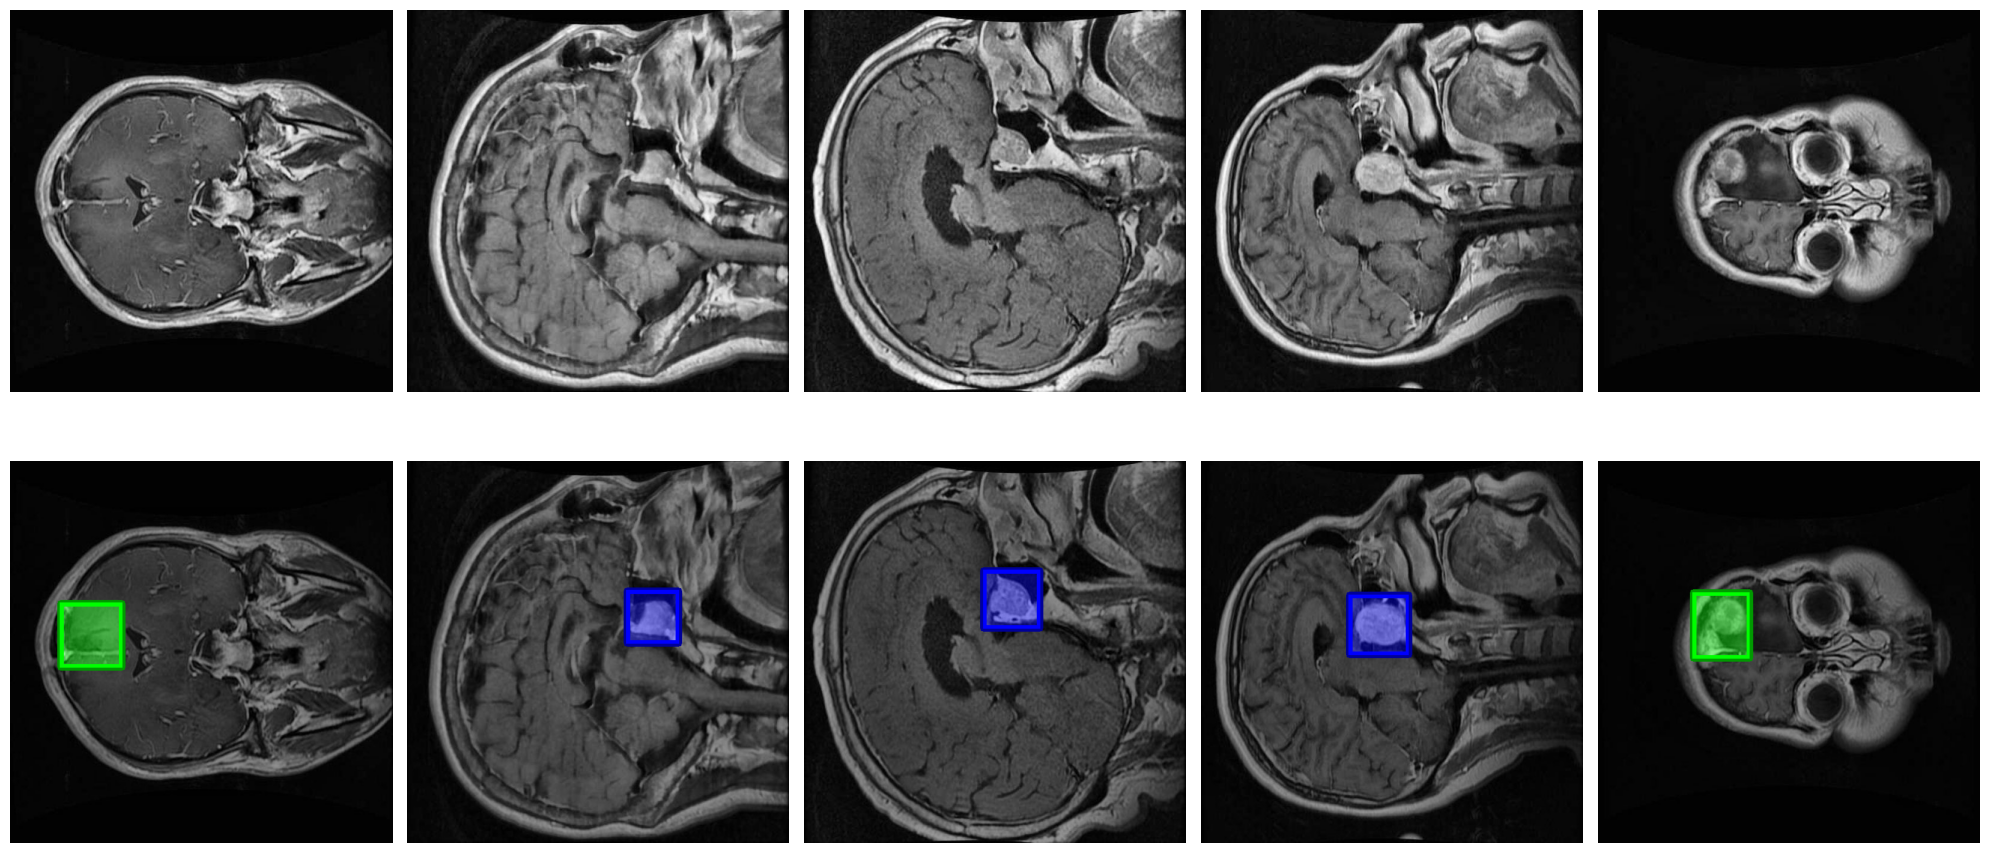

In [3]:


# Define colors for each class
colors = {
    0: (255, 0, 0),  # Tumor (Red)
    1: (0, 255, 0),   # Other class (Green)
    2: (0, 0, 255)   # Other class (Green)
}

# Display 5 random images
num_images_to_display = 5
selected_images = np.random.choice(train_annotations_data['images'], num_images_to_display, replace=False)

# Set up matplotlib figure
fig, axes = plt.subplots(2, num_images_to_display, figsize=(20, 10))

# Loop through selected images and display them with segmentation masks
for i, image_info in enumerate(selected_images):
    image_id = image_info['id']
    image_file_name = image_info['file_name']
    image_path = os.path.join(train_folder_path, image_file_name)
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display raw image
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    
    # Find annotations for the current image
    annotations = [ann for ann in train_annotations_data['annotations'] if ann['image_id'] == image_id]
    
    # Create a mask image for overlaying segmentation
    mask = np.zeros_like(image)
    
    # Loop through annotations and draw segmentation masks
    for ann in annotations:
        category_id = ann['category_id']
        segmentation = ann['segmentation']
        bbox = ann['bbox']
        print(bbox)
        color = colors[category_id]
        # Extract bounding box coordinates
        x, y, w, h = [int(coord) for coord in bbox]
        
        # Draw bounding box on the image
        segmented_image = cv2.rectangle(image, (x, y), (x + w, y + h), color, 10)
        
        # Draw segmentation mask
        for segment in segmentation:
            points = np.array(segment).reshape((-1, 1, 2)).astype(np.int32)
            cv2.fillPoly(mask, [points], color)
            
    
    # Overlay segmentation mask on the original image
    segmented_image = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    
    # Display image with segmentation
    axes[1, i].imshow(segmented_image)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Create the Databasesimport os


In [4]:
## all images are clean and 640 by 640

import os
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, data_folder, annotations, image_size=(640, 640), transform=None):
        self.data_folder = data_folder
        self.annotations = annotations
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        # print(len(self.annotations["images"]))
        return len(self.annotations["images"])

    def __getitem__(self, idx):
        # Load image
        image_list = self.annotations["images"]
        # print("id", image_list[idx]["id"])
        img_name = os.path.join(self.data_folder, image_list[idx]['file_name'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        
        # Generate mask
        mask = self.generate_mask_from_annotations(idx)
        # print("mask", mask)

        return image, mask

    def generate_mask_from_annotations(self, idx):
        # Generate mask from annotations
        
        mask = np.zeros(self.image_size, dtype=np.uint8)
        #mask = np.zeros((*self.image_size, self.num_classes), dtype=np.uint8)
        
        this_image_annotations = self.annotations["annotations"][idx]
        # print(this_image_annotations)
        category_id = this_image_annotations["category_id"]
        polygons_list = this_image_annotations["segmentation"]
        # print("category_id", category_id)
        # print("polgyons_list", polygons_list)
        
        for points in polygons_list:
            # Extract annotation points and draw rectangle on the mask
            # Last point is the same as the first point
            # print("points", points)
            
            rect_points = np.array(points, dtype=np.int32).reshape((-1, 2))
            # print("rect_points", rect_points)
            mask = cv2.fillPoly(mask, [rect_points], color=(255))
            
        if self.transform:
            mask = self.transform(mask)
        
        #lets do one class only
        mask[mask > 0] = 1
            
        return mask

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240, 240)),  # Resize to a standard size 240, 240 works fine, 224 from facebook model
    transforms.ToTensor(),
])



Train Dataset <__main__.ImageDataset object at 0x7fba64593d90>
Val Dataset <__main__.ImageDataset object at 0x7fba64593eb0>
Length of train dataset: 1502
Length of validation dataset: 429
Length of train_annotations_data: 5
Length of valid_annotations_data: 5
Length of train_annotations_data[images]: 1502
Length of valid_annotations_data[images]: 429


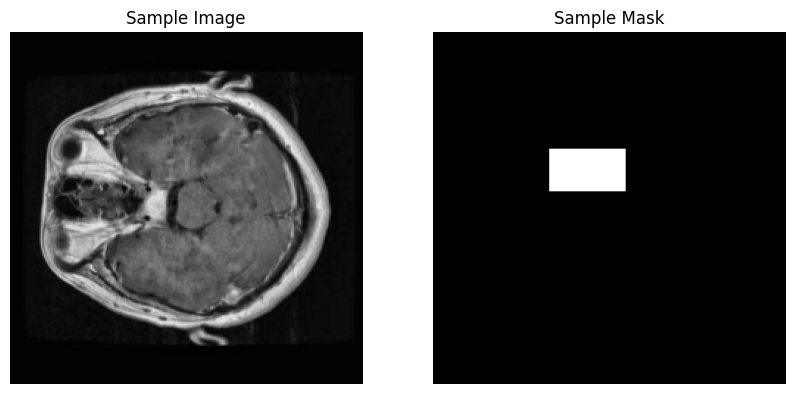

In [5]:
import random

# Define data paths
train_data_folder = os.path.join(data_folder_path, 'train')
val_data_folder = os.path.join(data_folder_path, 'valid')

# Create datasets
train_dataset = ImageDataset(train_data_folder, train_annotations_data, image_size=(640, 640), transform=transform)
val_dataset = ImageDataset(val_data_folder, valid_annotations_data, image_size=(640, 640), transform=transform)

print("Train Dataset", train_dataset)
print("Val Dataset", val_dataset)

print("Length of train dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))
print("Length of train_annotations_data:", len(train_annotations_data))
print("Length of valid_annotations_data:", len(valid_annotations_data))
print("Length of train_annotations_data[images]:", len(train_annotations_data["images"]))
print("Length of valid_annotations_data[images]:", len(valid_annotations_data["images"]))



# Visualize a sample from the dataset
sample_index = random.randint(0, len(train_dataset))
sample_image, sample_mask  = train_dataset[sample_index]

# Convert tensors to numpy arrays
sample_image= sample_image.permute(1, 2, 0).numpy()
sample_mask= sample_mask.permute(1, 2, 0).numpy()

# sample_mask = sample_mask.numpy()

# Display sample image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Sample Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Sample Mask")
plt.axis('off')

plt.show()



## Create Data Loader

Checking train dataset with DataLoader:
images in batch


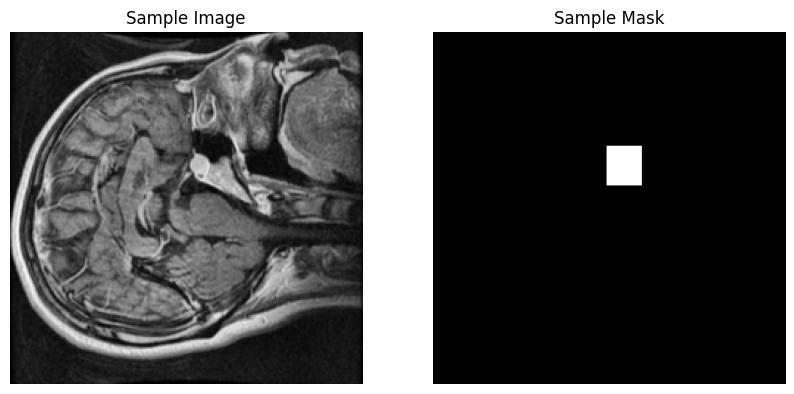

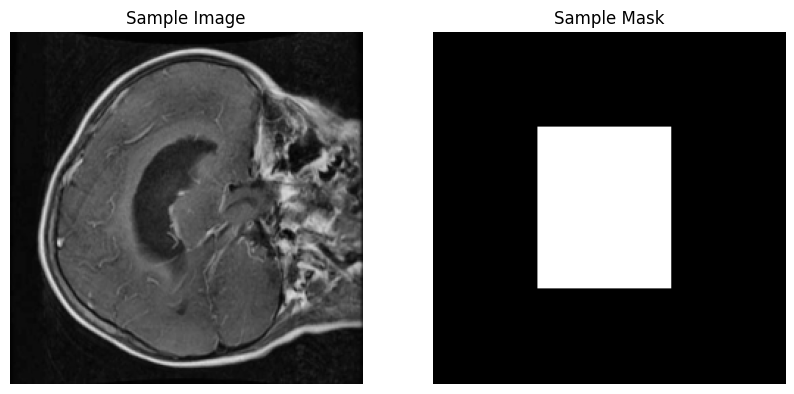

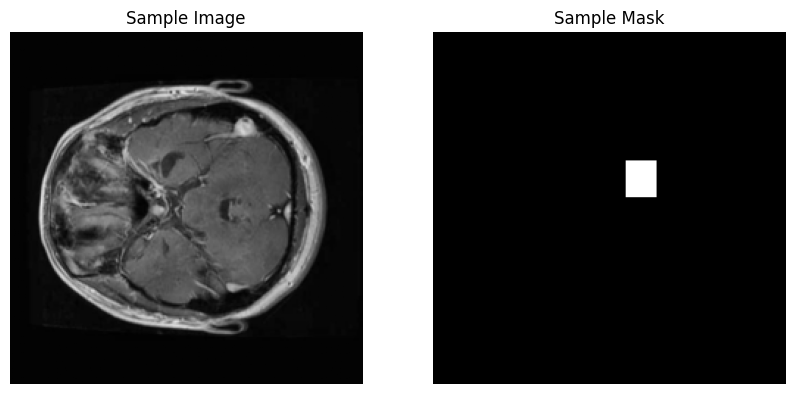

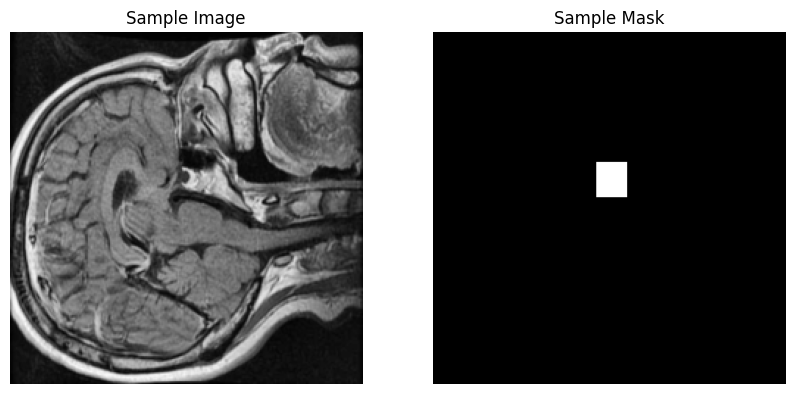

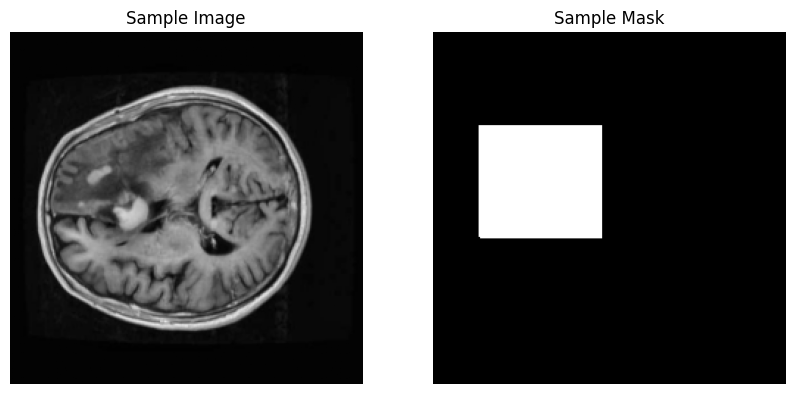

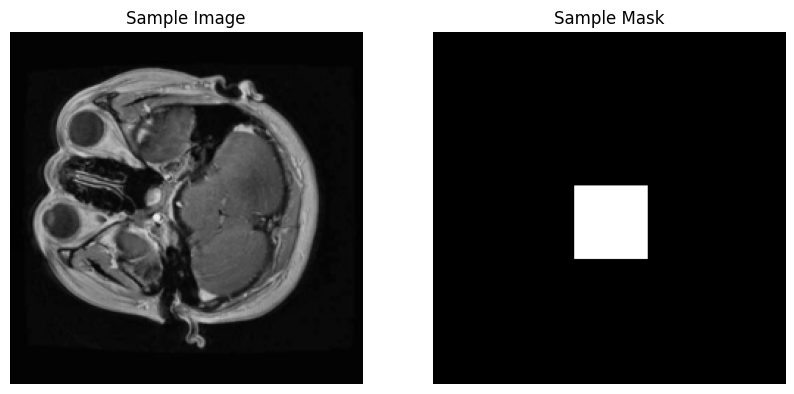

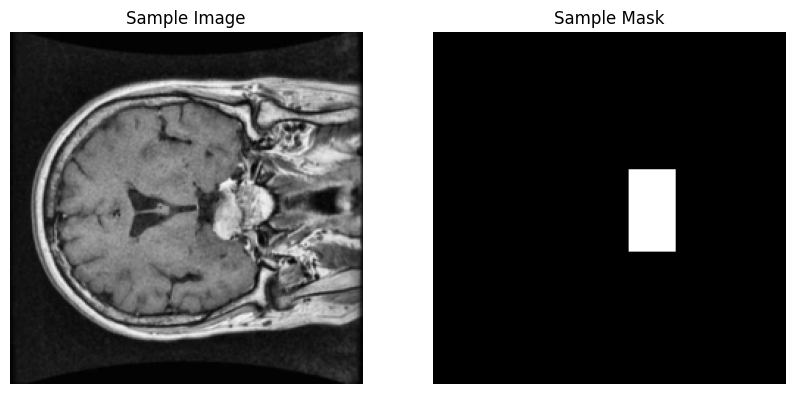

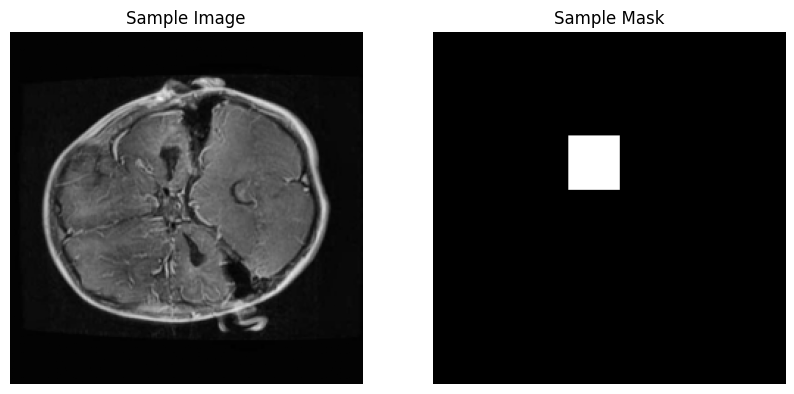

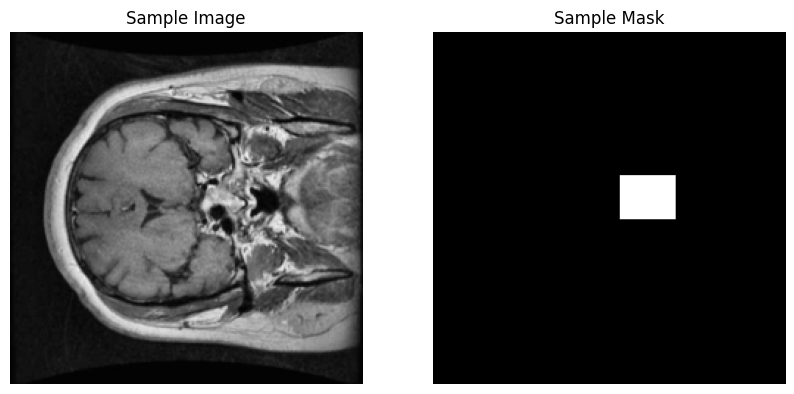

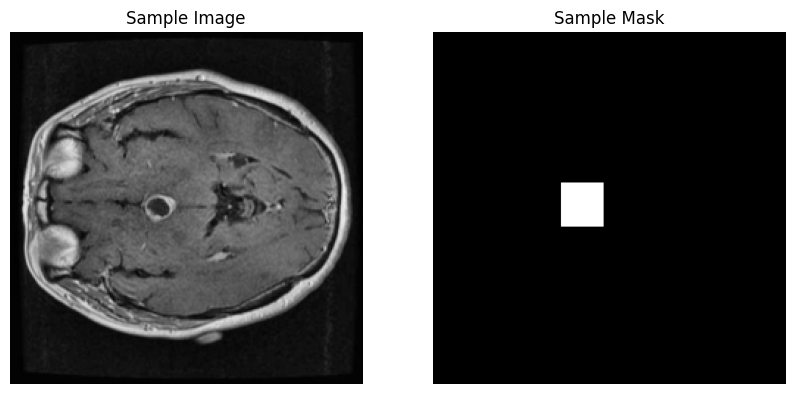

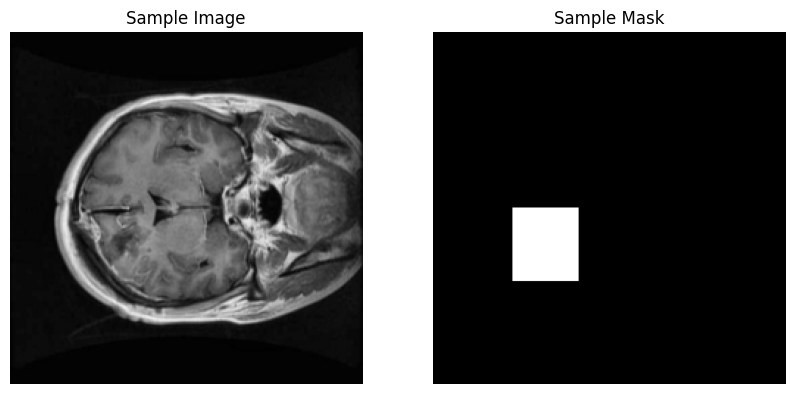

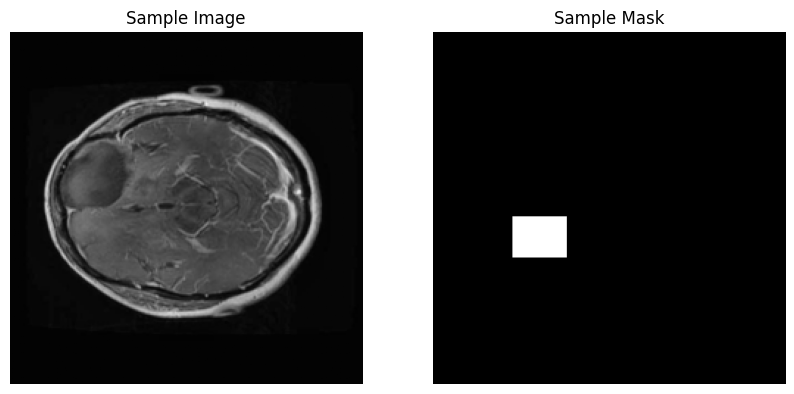

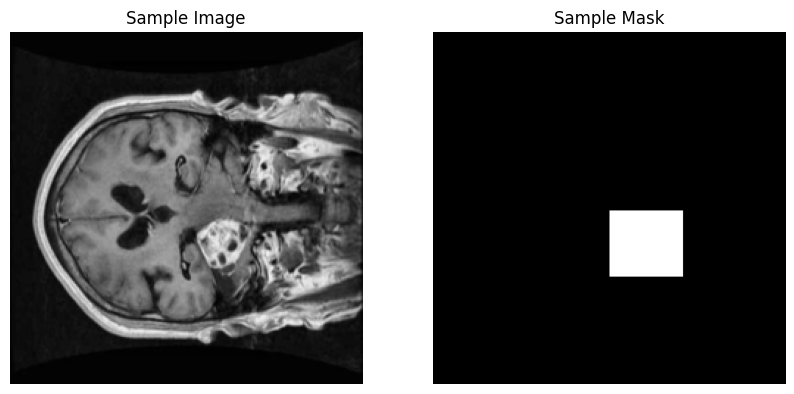

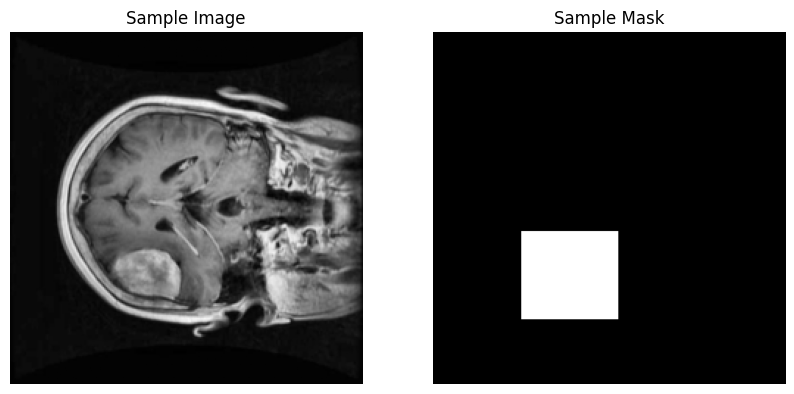

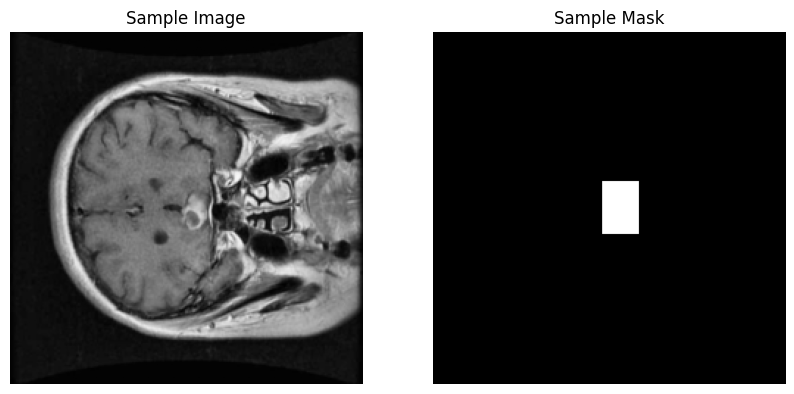

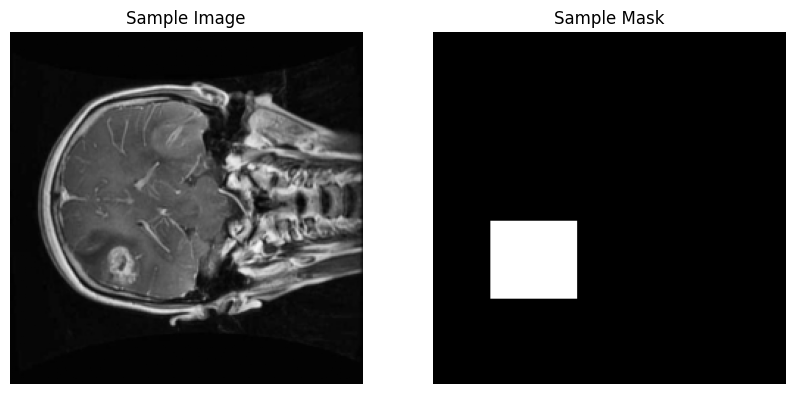

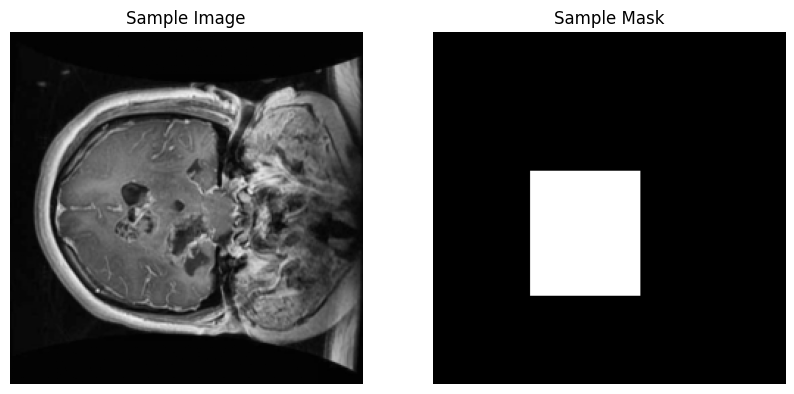

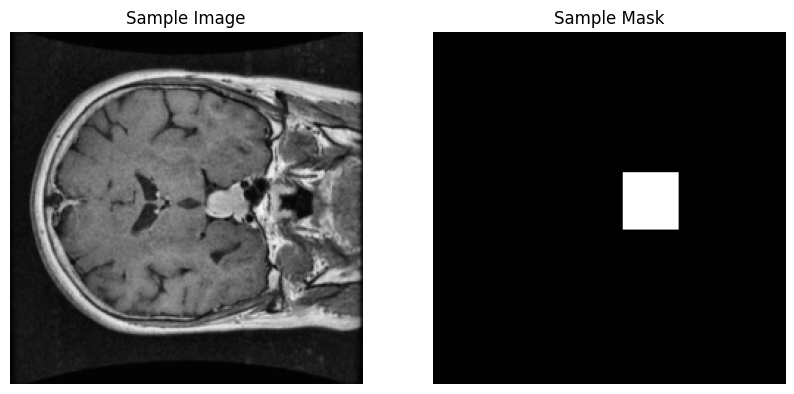

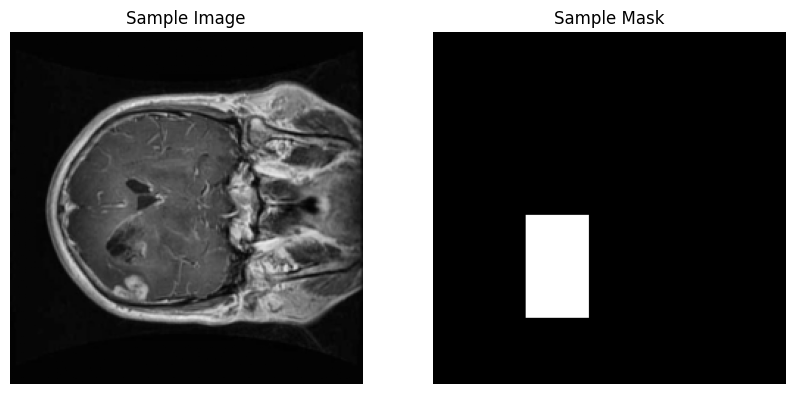

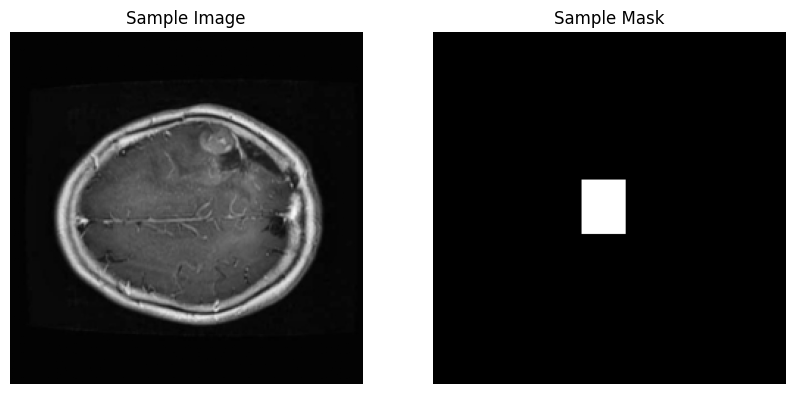

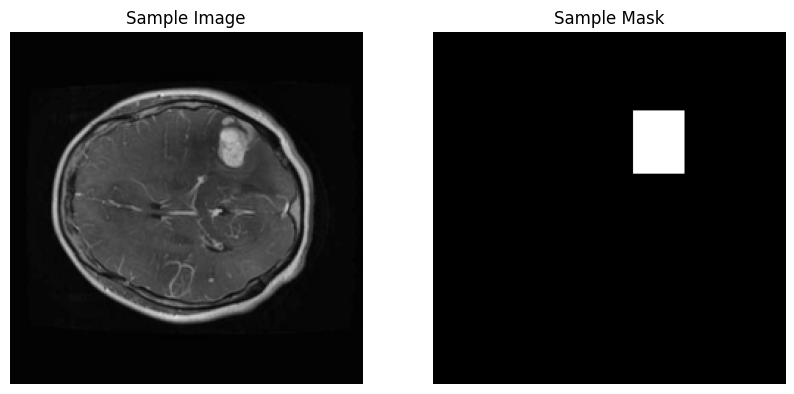

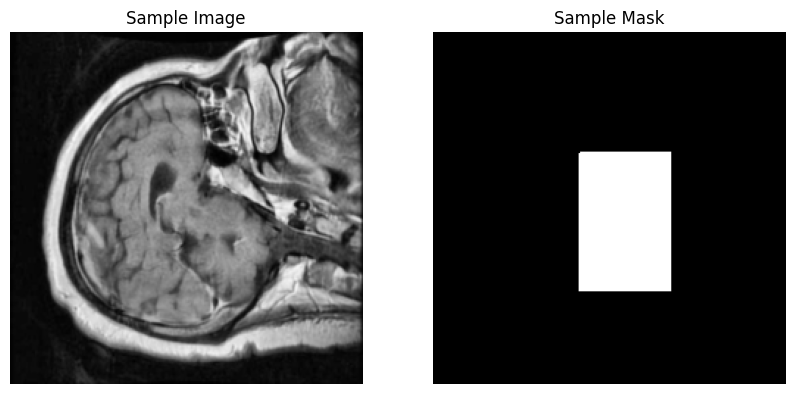

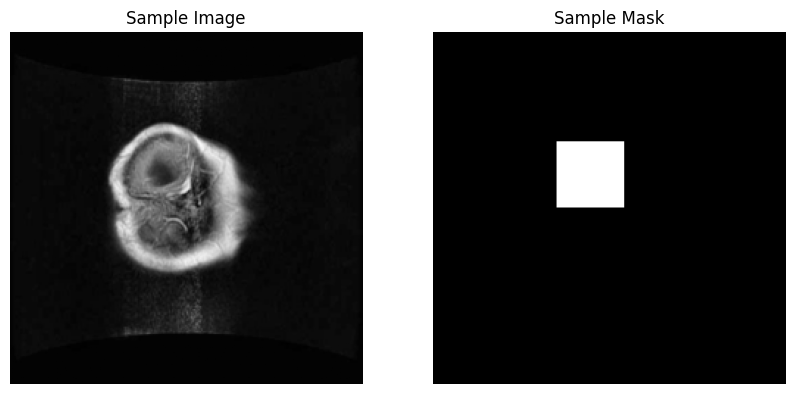

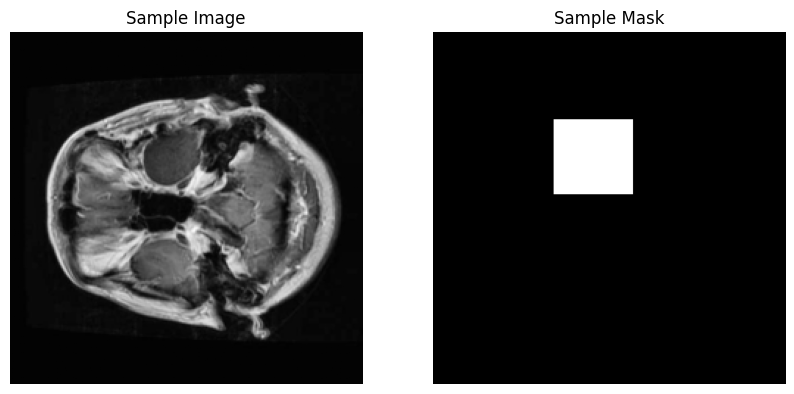

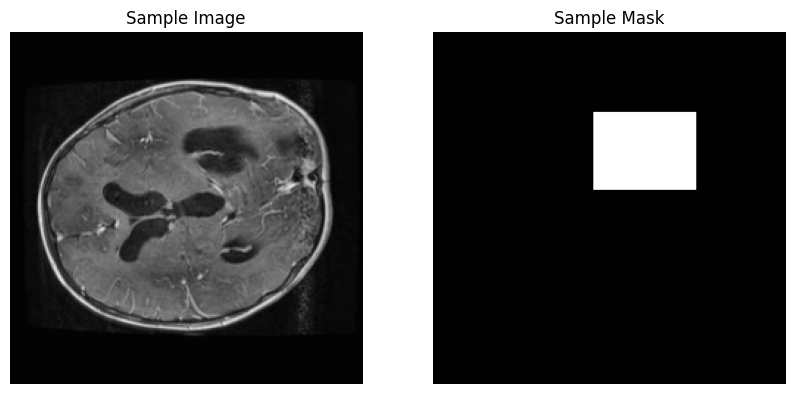

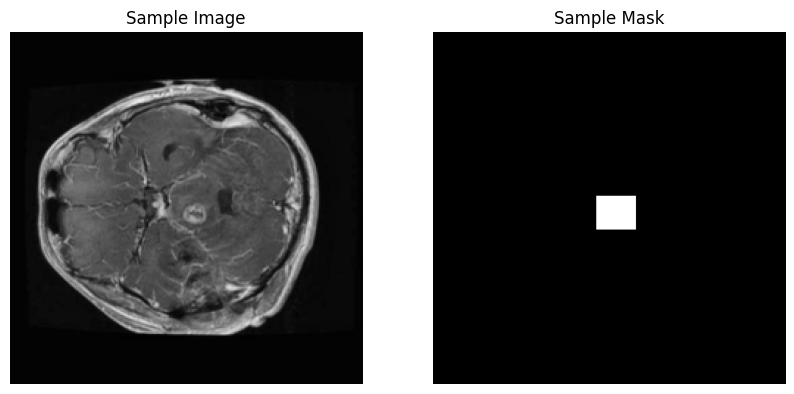

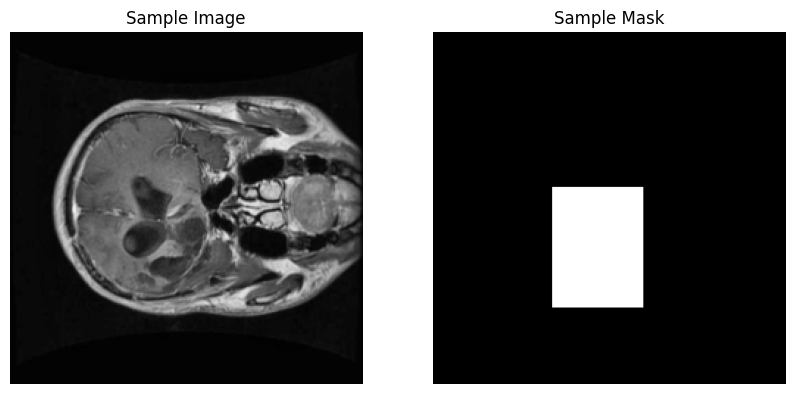

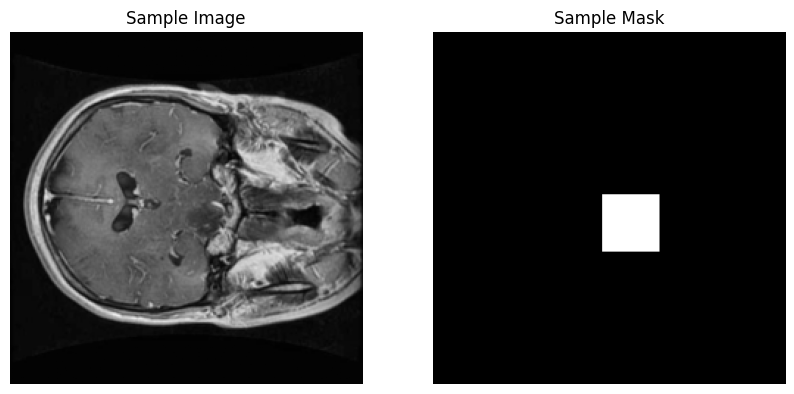

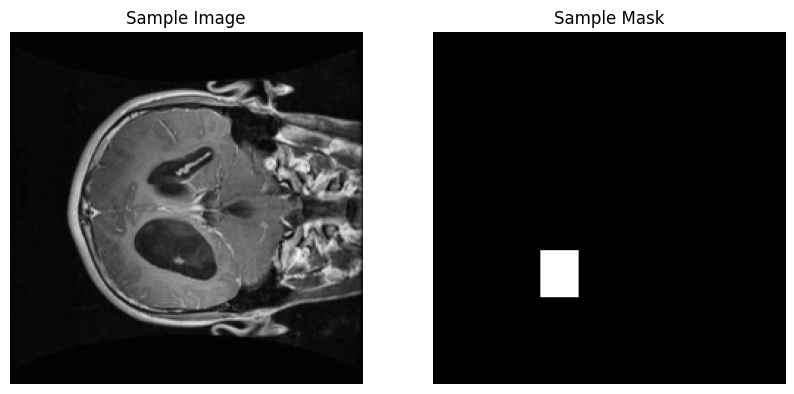

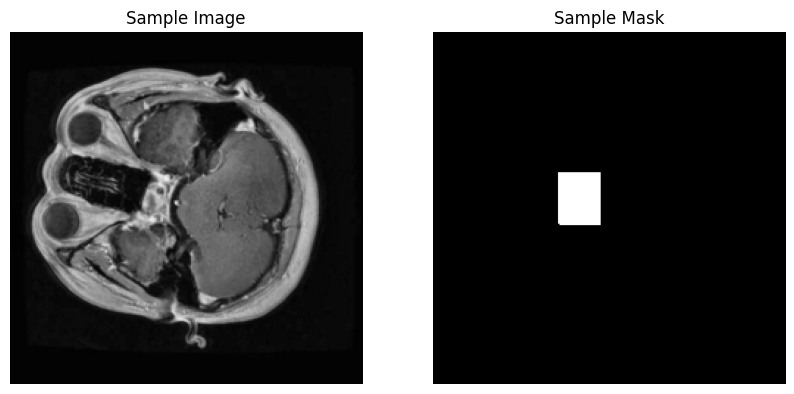

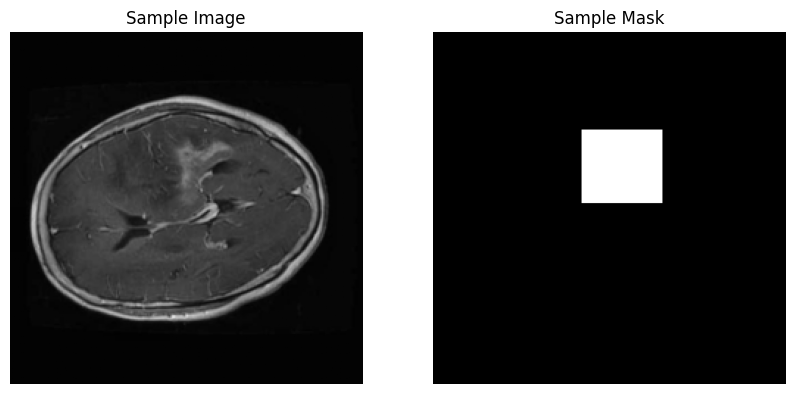

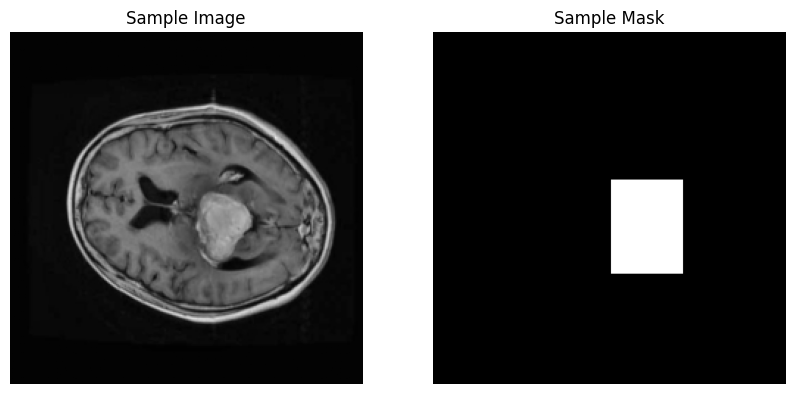

In [6]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32  # Adjust as needed

# Create DataLoader instances for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Check train dataset with DataLoader
print("Checking train dataset with DataLoader:")
for batch in train_loader:
    images, masks = batch  # Assuming your dataset returns images and masks
    # Perform any additional checks or processing as needed
    # Make sure the shapes and datatypes of images and masks are as expected
    # Check for any errors or inconsistencies
    # Display the image and mask
    

    print("images in batch")
    for image, mask in zip(images, masks):
        # Convert tensors to numpy arrays
        image = image.permute(1, 2, 0).numpy()
        mask = mask.permute(1, 2, 0).numpy()

        # Plot the image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Sample Image")
        plt.axis('off')

        # Plot the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask.squeeze(), cmap='gray')  # Assuming masks are single-channel
        plt.title("Sample Mask")
        plt.axis('off')

        plt.show()
    break


# Check validation dataset with DataLoader
# print("\nChecking validation dataset with DataLoader:")
# for batch in val_loader:
#     images, masks = batch  # Assuming your dataset returns images and masks
#     # Perform any additional checks or processing as needed
#     # Make sure the shapes and datatypes of images and masks are as expected
#     # Check for any errors or inconsistencies


## Model Architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models


class SimpleSegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.sigmoid(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.encoder_conv1 = self.conv_block(in_channels, 64)
        
        self.encoder_conv2 = self.conv_block(64, 128)
        
        self.encoder_conv3 = self.conv_block(128, 256)
        
        self.encoder_conv4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (upsampling path)
        self.decoder_upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder_conv1 = self.conv_block(1024, 512)
        
        self.decoder_upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder_conv2 = self.conv_block(512, 256)
        
        self.decoder_upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder_conv3 = self.conv_block(256, 128)
        
        self.decoder_upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder_conv4 = self.conv_block(128, 64)

        # Output layer
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder_conv4(F.max_pool2d(enc3, kernel_size=2, stride=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))

        # Decoder
        dec1 = self.decoder_upconv1(bottleneck)
        dec1 = self.decoder_conv1(torch.cat([enc4, dec1], dim=1))
        
        dec2 = self.decoder_upconv2(dec1)
        dec2 = self.decoder_conv2(torch.cat([enc3, dec2], dim=1))
        
        dec3 = self.decoder_upconv3(dec2)
        dec3 = self.decoder_conv3(torch.cat([enc2, dec3], dim=1))
        
        dec4 = self.decoder_upconv4(dec3)
        dec4 = self.decoder_conv4(torch.cat([enc1, dec4], dim=1))

        # Output layer
        output = self.output_conv(dec4)

        return torch.sigmoid(output)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

class MobileNetV2WithCustomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithCustomClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[-1] = nn.Conv2d(1280, num_classes, kernel_size=1)

    def forward(self, x):
        features = self.mobilenet.features(x)
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.mobilenet.classifier(out)
        return out


## Load the Models

In [8]:
#best cases: lr = 0.001, Unet, BCEloss. 
# Unet 3, 1 class, BCEloss, ADAm lr = 0.0001, 40 epochs

# Define the number of classes
num_classes = 1  # Adjust as needed

# Custom Models
# model = SimpleSegmentationModel(num_classes)
model = UNet(3, num_classes)
model = model.to(device)

# Pretrained models
# model = MobileNetV2WithCustomClassifier(num_classes)
# model = model.to(device)

# Define the loss function
criterion = nn.BCELoss()
# criterion = criterion.to(device)

# Define the loss function
# criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for numerical stability
criterion = criterion.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# optimizer = optim.AdamW(model.parameters(), lr=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90) #0.99

# print(model)

## Training

In [9]:
# Training loop
import time

num_epochs = 40 # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start timer for epoch
    model.train()
    running_train_loss = 0.0
    for images, masks in train_loader:
        # print("New Batch")
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.to(device)
        
        loss = criterion(outputs, masks)
        # print("loss" ,loss)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = outputs.to(device)
            
            
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    
    end_time = time.time()  # End timer for epoch
    epoch_time = end_time - start_time  # Calculate epoch time
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Time: {epoch_time:.2f} seconds")


Epoch 1, Train Loss: 0.39051761208696567, Val Loss: 0.1919378638267517, Time: 83.39 seconds
Epoch 2, Train Loss: 0.15970910324695262, Val Loss: 0.14074510761669703, Time: 83.61 seconds
Epoch 3, Train Loss: 0.12872286901829091, Val Loss: 0.13091657044632093, Time: 84.29 seconds
Epoch 4, Train Loss: 0.12315714375135746, Val Loss: 0.12364946784717697, Time: 85.07 seconds
Epoch 5, Train Loss: 0.12054023099072436, Val Loss: 0.12134359989847456, Time: 85.26 seconds
Epoch 6, Train Loss: 0.11833355100230968, Val Loss: 0.11940842707242284, Time: 85.65 seconds
Epoch 7, Train Loss: 0.11688223211689198, Val Loss: 0.1208185867539474, Time: 85.47 seconds
Epoch 8, Train Loss: 0.11611839257022168, Val Loss: 0.1187209455030305, Time: 87.44 seconds
Epoch 9, Train Loss: 0.11542357995789101, Val Loss: 0.11683228186198644, Time: 88.81 seconds
Epoch 10, Train Loss: 0.11496435026539133, Val Loss: 0.11731315138084548, Time: 87.41 seconds
Epoch 11, Train Loss: 0.11443294854240214, Val Loss: 0.11545301601290703

## Save Model

In [11]:
# Specify the file path where you want to save the model weights
# checkpoint_path = '/home/jws2215/eecs6691-final-project-jws2215/saved_weights/unet_model_weights3.pth'
checkpoint_path = '/home/jws2215/saved_weights/unet_model_weights3.pth'
# Save the model weights
torch.save(model.state_dict(), checkpoint_path)

## Evaluation

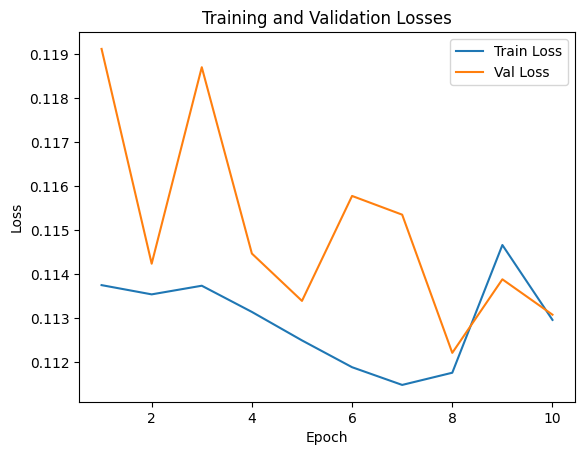

In [39]:

# Plot training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

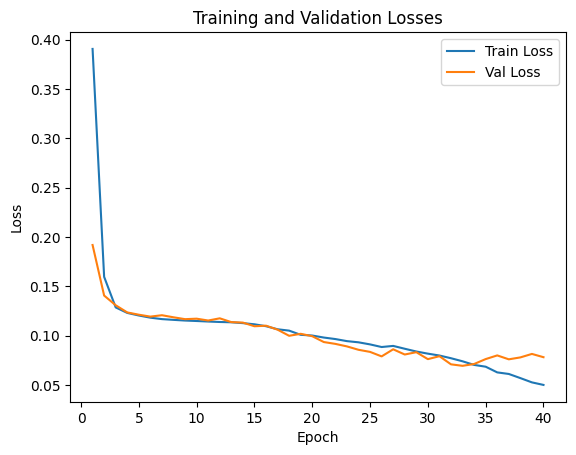

In [12]:
#weights 3
# Plot training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

images in batch


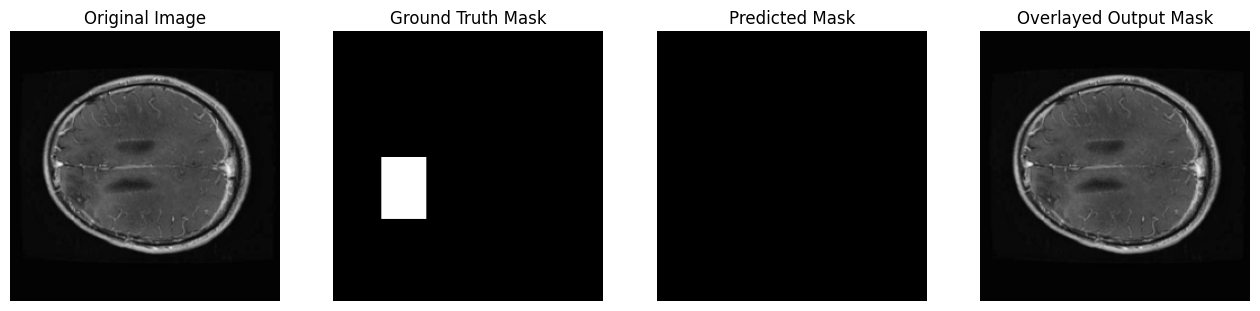

images in batch


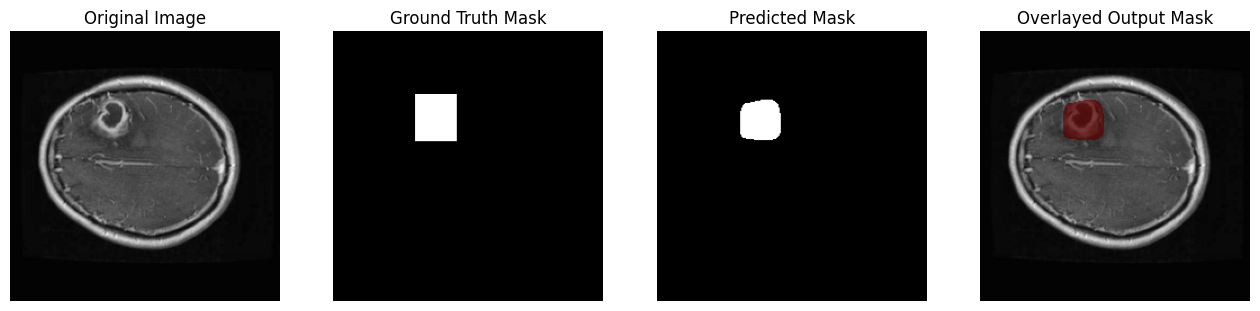

images in batch


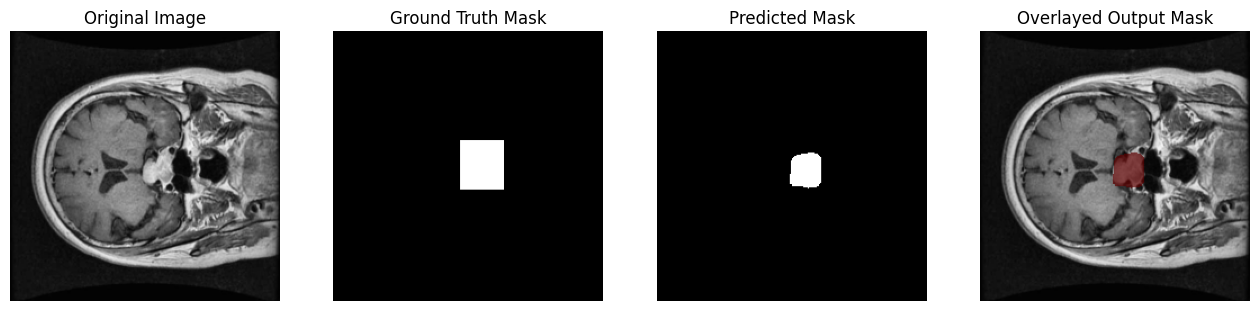

images in batch


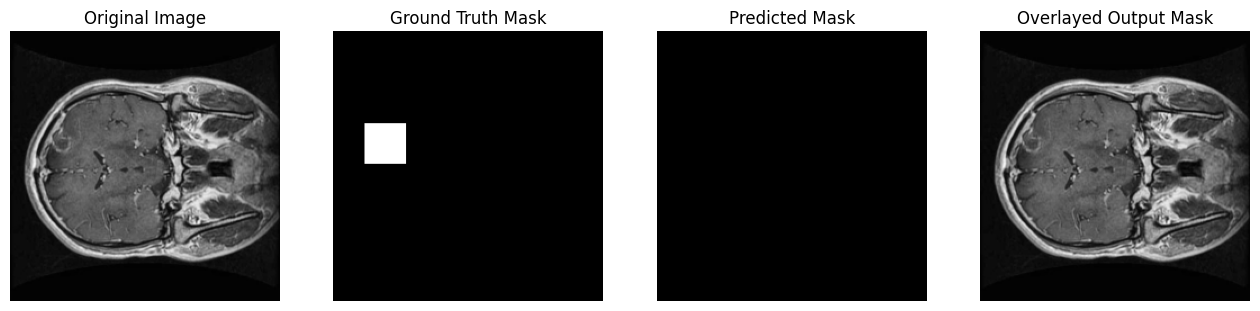

images in batch


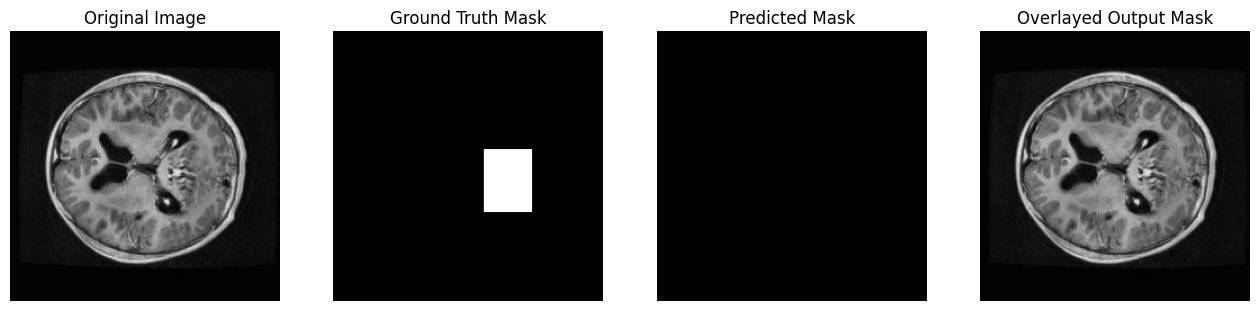

images in batch


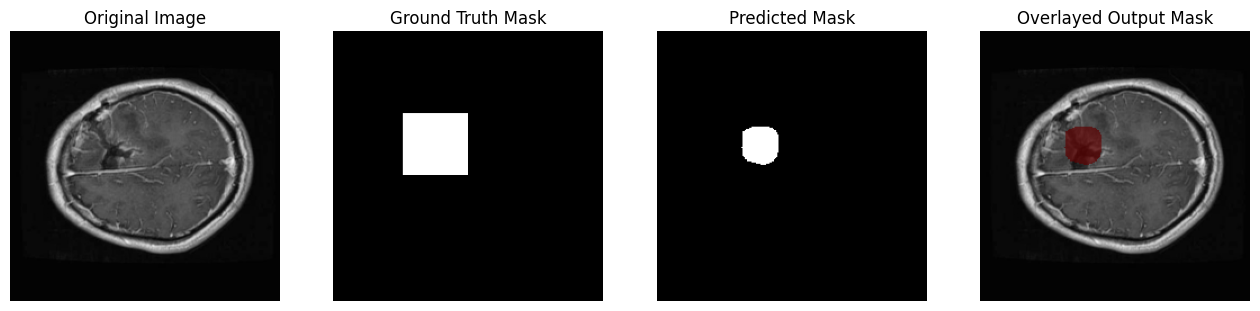

images in batch


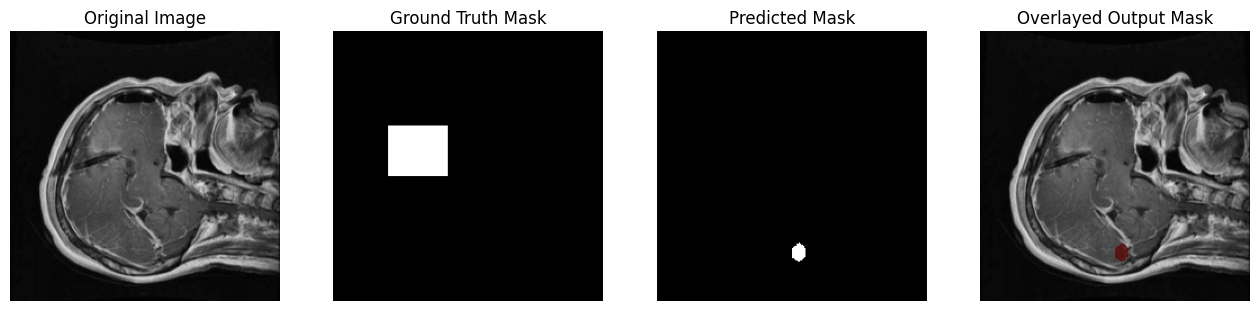

images in batch


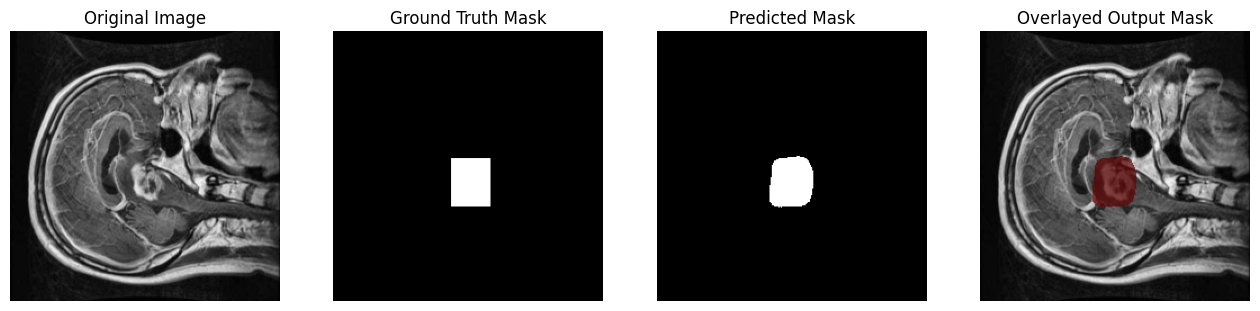

images in batch


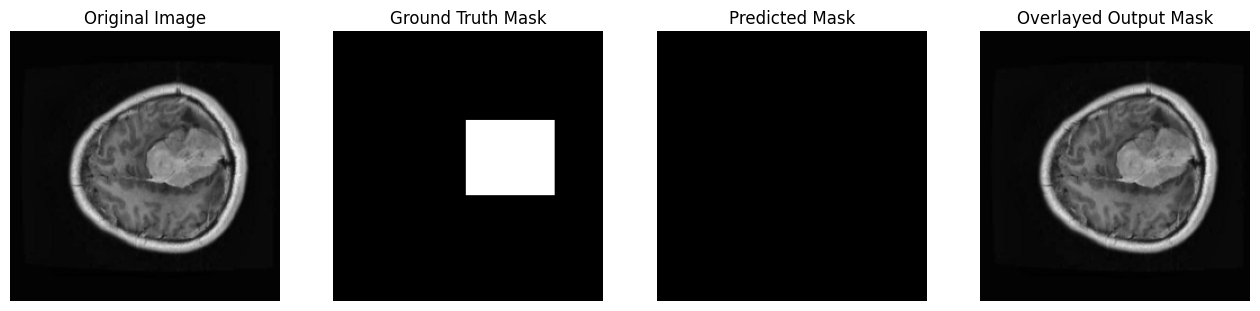

images in batch


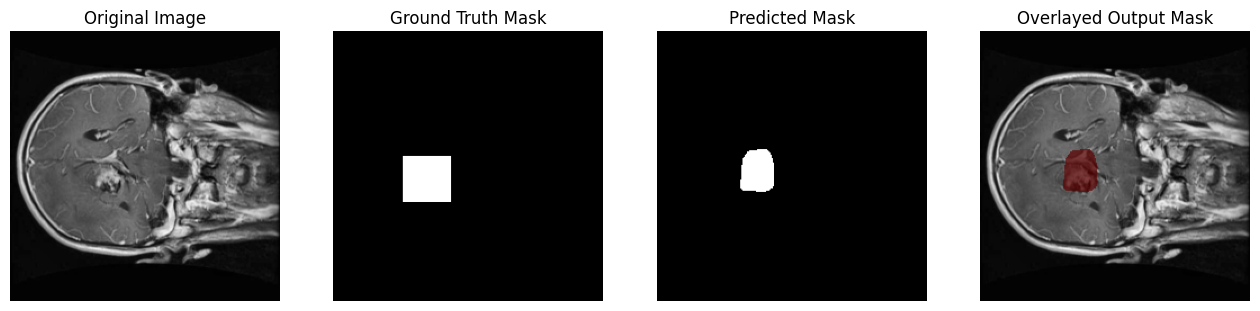

images in batch


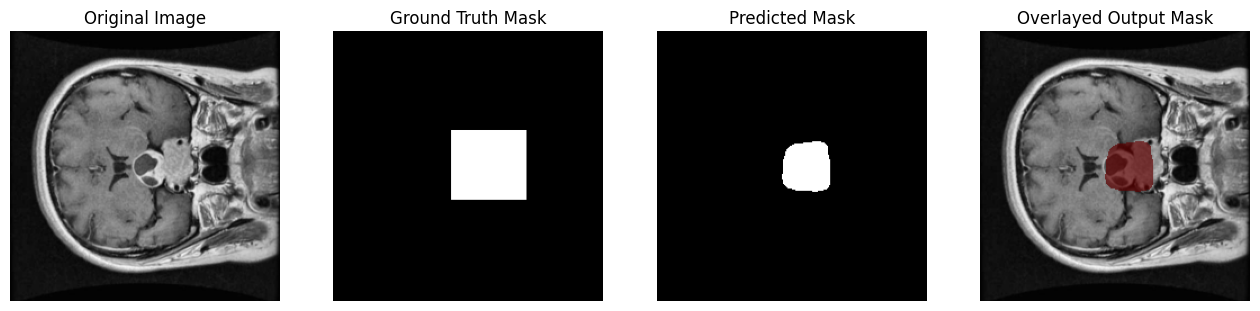

images in batch


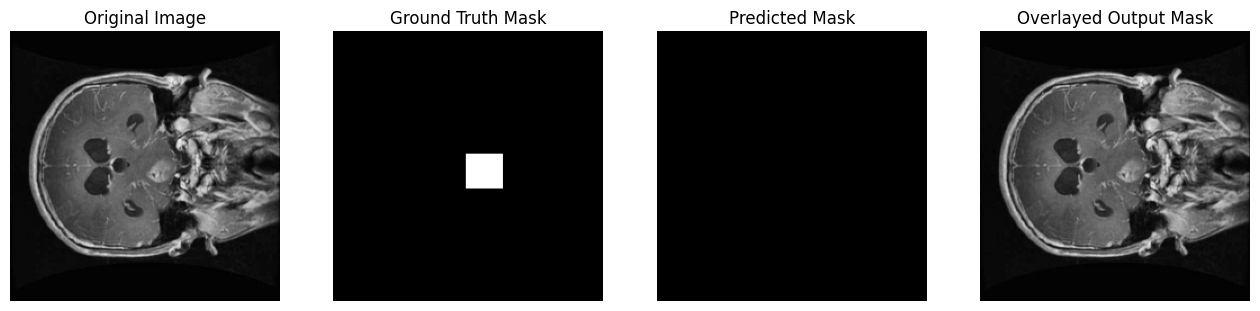

images in batch


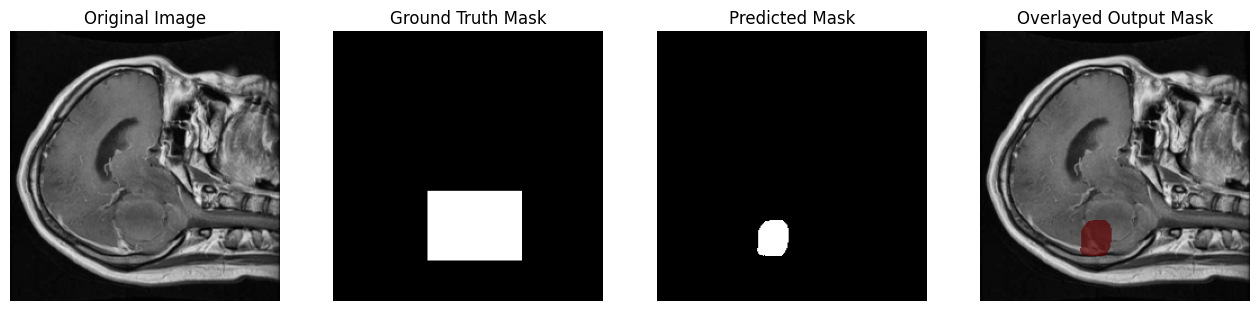

images in batch


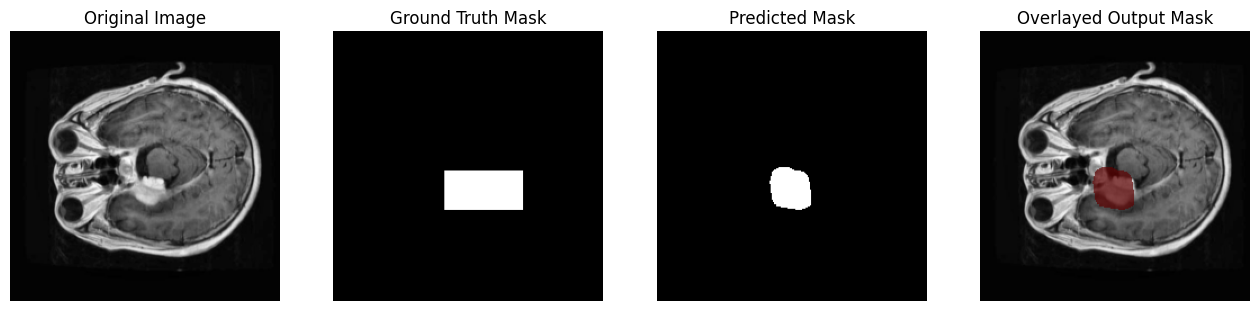

In [16]:
display_threshold = 0.9


for batch in val_loader:
    images, masks = batch  # Assuming your dataset returns images and masks
    # Perform any additional checks or processing as needed
    # Make sure the shapes and datatypes of images and masks are as expected
    # Check for any errors or inconsistencies
    # Display the image and mask
    

    print("images in batch")
# Convert tensors to numpy arrays
        
    sample_image = images.to(device)
    sample_output = model(sample_image)

    sample_image = sample_image.cpu()
    sample_mask = masks.cpu()
    sample_output = sample_output.cpu()

    sample_image = sample_image[0].permute(1, 2, 0).numpy()
    sample_mask = sample_mask[0].permute(1, 2, 0).numpy()
    sample_output = sample_output[0].squeeze().detach().numpy()

    #threshold applied
    sample_output = (sample_output > display_threshold).astype(np.uint8)
    
    #apply overlay
    # Overlay the predicted mask on top of the original image
    red_color = np.array([255, 0, 0], dtype=np.uint8)
    overlay_image = sample_image.copy()
    overlay_image[sample_output == 1] = overlay_image[sample_output == 1] * 0.3 + red_color * 0.001  # Mix red with original image

    

    # Plot the images and masks
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(sample_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(sample_output, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_image)
    plt.title("Overlayed Output Mask")
    plt.axis('off')

    plt.show()